In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import time

In [ ]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


In [ ]:
import pandas as pd
data=pd.read_csv('cpi.csv')
data.head

<bound method NDFrame.head of       tg       t     cpi
0      0  Jan-95  103.80
1      1  Feb-95  103.40
2      2  Mar-95  100.20
3      3  Apr-95  101.00
4      4  May-95  101.80
..   ...     ...     ...
319  319  Aug-21  100.25
320  320  Sep-21   99.38
321  321  Oct-21   99.80
322  322  Nov-21  100.32
323  323  Dec-21   99.82

[324 rows x 3 columns]>

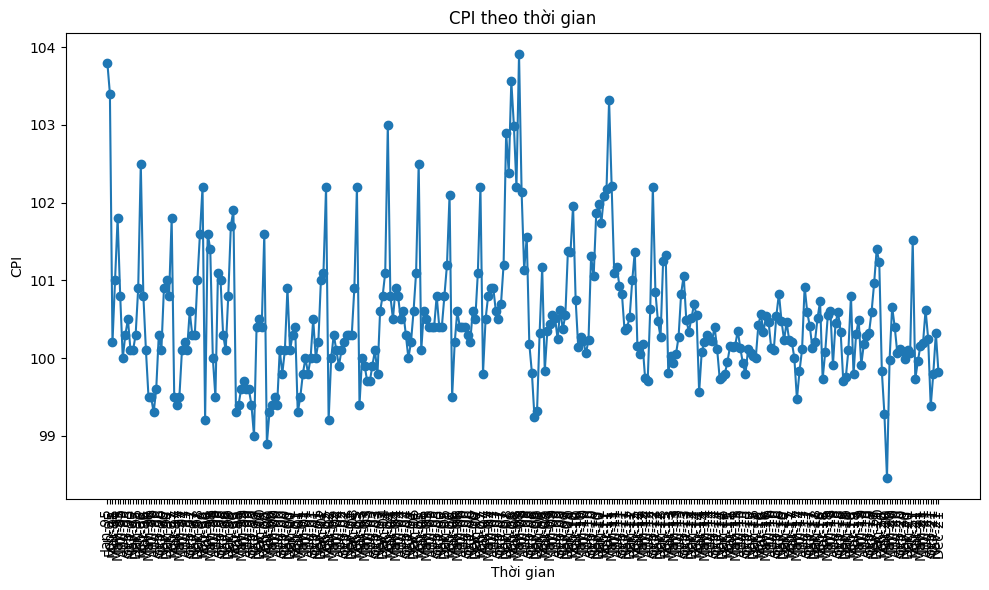

In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists
time_step = []
cpi = []

# Open CSV file
with open('cpi.csv', 'r') as csvfile:
    # Initialize reader
    reader = csv.reader(csvfile)

    # Skip the first line
    next(reader)

    # Append values to lists
    for row in reader:
        time_step.append(row[1])  # Thời gian (ví dụ: "Jan-95")
        cpi.append(float(row[2]))  # CPI

# Convert lists to numpy arrays (cho cột CPI)
series = np.array(cpi)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(time_step, series, marker='o', linestyle='-')
plt.xlabel('Thời gian')
plt.ylabel('CPI')
plt.title('CPI theo thời gian')
plt.xticks(rotation=90)  # Xoay nhãn trục x cho dễ đọc
plt.tight_layout()
plt.show()


In [ ]:
# Define the split time
split_time =int( 0.85*len(series))

# Get the train set
time_train = time_step[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time_step[split_time:]
x_valid = series[split_time:]
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [ ]:
import time
start_time = time.time()
# Build the Model
# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])

# Train the model
history = model.fit(dataset,epochs=100)
end_time = time.time()
train_time_cls = end_time - start_time
print(f'Thời gian huấn luyện mô hình RNN: {train_time_cls:.4f} giây')

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 69.5651 - mse: 4914.3833
Epoch 2/100
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 58.8035 - mse: 3520.9822

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 55.1372 - mse: 3121.6995
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 32.3593 - mse: 1116.1752
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 7.7488 - mse: 86.7372
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 8.1416 - mse: 75.9644
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.1339 - mse: 8.3115
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 1.1769 - mse: 3.6392
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.5821 - mse: 1.5391
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.5429 - mse: 1.2717
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.4214 - mse: 1.1037
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.2955 - mse: 0.7496
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.2805 - mse: 0.6886
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2615 - mse: 0.6512
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


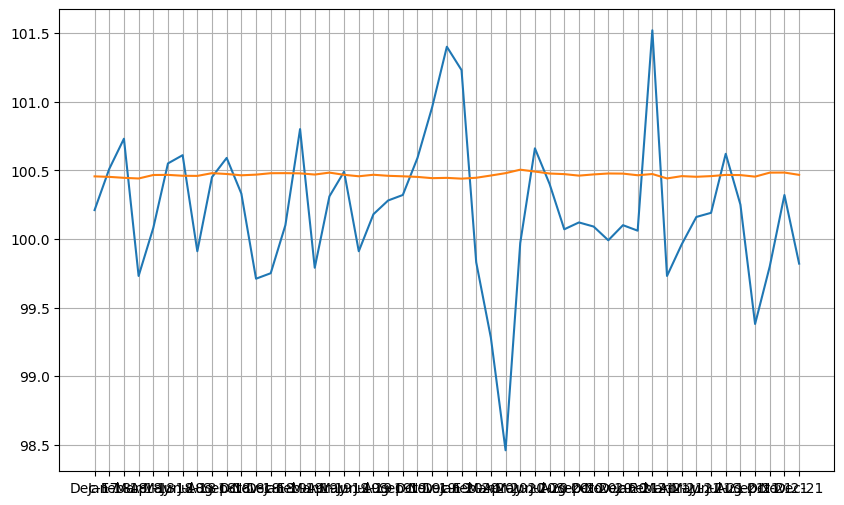

[100.45563  100.45196  100.44501  100.44013  100.46562  100.4665
 100.460075 100.459076 100.47898  100.4729   100.463425 100.46828
 100.47858  100.47911  100.477516 100.46891  100.48299  100.467064
 100.456345 100.46735  100.45973  100.45617  100.45164  100.44254
 100.44464  100.43903  100.44547  100.46185  100.47902  100.50432
 100.49081  100.47633  100.47207  100.46098  100.4699   100.47662
 100.475716 100.4638   100.47269  100.4406   100.45736  100.45265
 100.45749  100.46611  100.46503  100.45369  100.48285  100.48343
 100.46654 ]
MSE: 0.3375224722038799
Mean Error Percent: 0.004509712290657335
Accuracy: 0.9954902877093427


In [ ]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))


print(results)

# Giả sử x_valid và results là các mảng dự đoán và giá trị thực
x_valid = np.array(x_valid)
results = np.array(results)

# Tính Mean Squared Error
mse = np.mean(np.square(x_valid - results))
print("MSE:", mse)

# Tính Mean Absolute Percentage Error (MAPE)
non_zero_indices = x_valid != 0  # Đảm bảo không có giá trị 0 trong mẫu
mean_error_percent = np.mean(np.abs((x_valid[non_zero_indices] - results[non_zero_indices]) / x_valid[non_zero_indices]))
accuracy = 1 - mean_error_percent  # Tính accuracy từ MAPE

print("Mean Error Percent:", mean_error_percent)
print("Accuracy:", accuracy)
